In [1]:
import numpy as np
from numpy import trapz
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.table import Table,vstack,Column,join
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc

In [2]:
def get_good_sed_fit_mask(catalogue,sed_fitting_code):
    #returns a mask that identifies good fits from a given results table from one of the four SED fitting codes
    #Magphys, AGNfitter, CIGALE and BAGPIPES
    if sed_fitting_code != ('magphys' or 'agnfitter' or 'cigale' or 'bagpipes'):
        print('catalogue not associtaed with any known sed fitter. Please provide SED fitter')
        return()
    #returns the magphys mask using the chi2_99_flag column which is described in Smith et al 2012
    if sed_fitting_code=='magphys':
        mask = ~(catalogue['chi2_99_flag']==1.0)
        return(mask)
    #need to write AGN fitter section
    #need to write CIGALE section
    #need to write BAGPIPES section

In [3]:
def get_best_ldust(catalogue,ldust_colnames,ldust_err_colnames,sed_fitter):
    #returns two arrays conatining ldust and the error on ldust repsectively
    #it selects the best ldust estimate for each source in the given catalogue by looping over the given 
    #ldust column names. These must be given in the order of preference 
    #i.e the first column name given is the column whose ldust will be used above all others if available
    #the error column names must be ordered the same as the ldust column names
    #
    #it also needs a list containing the name of the sed fitting code
    #currently it only accepts 'magphys','cigale','agnfitter','bagpipes'
    
    ldust = np.zeros(len(catalogue))
    ldust_err = np.zeros(len(catalogue))
    for n,name in enumerate(ldust_colnames):
        
        good_sources = get_good_sed_fit_mask(catalogue,sed_fitter[n])
        if n==0:
            mask = (catalogue[name]>0) & good_sources
            ldust[mask] = catalogue[name][mask]
            ldust_err[mask] = catalogue[ldust_err_colnames[n]][mask]
        else:
            mask = (ldust==0) & (catalogue[name]>0) & good_sources
            ldust[mask] = catalogue[name][mask]
            ldust_err[mask] = catalogue[ldust_err_colnames[n]][mask]
            
    return(ldust,ldust_err)

In [4]:
#Read in the LOFAR catalogue
lofar = Table.read('../lofar/deep_fields/ELAIS-N1/data/data_release/final_cross_match_catalogue-v0.5.fits')
lofar[0]

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,flo

In [5]:
#read in the LOFAR SED fits for EN1
magphys_en1 = Table.read('../lofar/deep_fields/ELAIS-N1/data/magphys/ELAIS_N1_lowzmagphys_20200219.fits')
#need to write some code to change the units of ldust to watts here so the merged ldust catatlogue
#has consistent units in all teh ldust cols
magphys_cols = ['galaxy_id','Ldust_best','Ldust_sigma','Ldust_bayes','Ldust_03','Ldust_16','Ldust_50','Ldust_84','Ldust_98','chi2','chi2_99_flag']
magphys_ldust = magphys_en1[magphys_cols]
magphys_ldust.rename_column('galaxy_id','Source_Name')

for cat in [magphys_ldust]:
    for n,name in enumerate(magphys_cols):
        if n==0:
            continue
        cat[name] = cat[name]*3.8*10**26

magphys_ldust[0]

Source_Name,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,chi2,chi2_99_flag
bytes30,object,object,object,object,object,object,object,object,object,object
ILTJ161340.59+535110.1,2.1576399034777602e+40,4.8886320201728e+39,2.52396722716672e+40,1.7369351061504e+40,2.04072082735104e+40,2.51063504470016e+40,3.01844697972736e+40,3.4656409878528e+40,4.0283798217773437e+27,0.0


In [7]:
#join the SED catalogues with the LOFAR table

SED_tables = [magphys_ldust]
print('lofar table has {} sources'.format(len(lofar)))
for n,catalogue in enumerate(SED_tables):
    if n==0:
        lofar_sed = join(lofar,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed)))
    else:
        lofar_sed = join(lofar_ldust,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed)))
    
lofar_sed[0]

lofar table has 31645 sources
new joined table has 31645 sources


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,chi2,chi2_99_flag
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes30,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64

In [8]:
#Read in the LOFAR and HERschel maps
fname = '../lofar/deep_fields/ELAIS-N1/data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

fname = '../lofar/deep_fields/ELAIS-N1/data/data_release/radio_rms_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs_err = wcs.WCS(radim_header).celestial
radim_err = hdulist[0].data[0][0]
hdulist.close()

#Read in the spire maps
imfolder='../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header

im250=hdulist['image'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['image'].header)
hdulist.close()

imfolder='../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE350_v1.0.fits'
hdulist = fits.open(pswfits)
im350phdu=hdulist[0].header
im350hdu=hdulist['image'].header

im350=hdulist['image'].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist['image'].header)
hdulist.close()

imfolder='../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE500_v1.0.fits'
hdulist = fits.open(pswfits)
im500phdu=hdulist[0].header
im500hdu=hdulist['image'].header

im500=hdulist['image'].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist['image'].header)
hdulist.close()

  'HZ' -> 'Hz'. [astropy.wcs.wcs]
  'HZ' -> 'Hz'.


In [9]:
#Read in the FIR luminosities for the additional HELP objects from CIGALE
cigale_HELP_input = Table.read('../lofar/deep_fields/ELAIS-N1/cigale/ldust/cigale_input.fits')
cigale_HELP_results = Table.read('../lofar/deep_fields/ELAIS-N1/cigale/ldust/results.fits')
joined_cigale_HELP = join(cigale_HELP_input,cigale_HELP_results,keys='id',join_type='inner')
joined_cigale_HELP[0]

#need to add a bit that removes HELP sources associated to LOFAR objects
mask = np.array([name in lofar['help_id'] for name in joined_cigale_HELP['id']])
joined_cigale_HELP = joined_cigale_HELP[~mask]
joined_cigale_HELP[0]

id,field,ra,dec,redshift,pacs_green,pacs_green_err,flag_pacs_green,pacs_red,pacs_red_err,flag_pacs_red,spire_250,spire_250_err,flag_spire_250,spire_350,spire_350_err,flag_spire_350,spire_500,spire_500_err,flag_spire_500,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.universe.redshift,bayes.universe.redshift_err,best.chi_square,best.reduced_chi_square,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.metallicity,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.pacs_green,best.pacs_red,best.spire_250,best.spire_350,best.spire_500
,,deg,deg,,mJy,,,mJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mJy,mJy,mJy,mJy,mJy
bytes1728,bytes18,float64,float64,float64,float32,float32,bool,float32,float32,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
HELP_J155620.810+545113.308,ELAIS-N1,239.086706815057,54.8536967354993,nan,nan,nan,False,nan,nan,False,20.906187,3.980425000000003,True,26.584743,4.480207000000002,True,28.536203,5.316896000000001,True,3.332098334866379e+39,1.876727810546632e+39,2.9135156893911605,0.7484849038046447,0.19156885148821887,0.09578442574410943,0.5,0.8,0.5634245423743864,1.5353171722901084,-0.7,-0.7,7.838460846971918e+38,1.2125123514699113e+39,2.0,0.02,1.996358436167103e+39,1.090006422740487e+40,0.47,5.0,0.0,0.0,2500.0,110.0,0.001,1246975411635.9436,751.4025551407252,748.8181758364088,751.1834145760563,10000.0,3000.0,907.8319250157256,1.0,3.0584107963961856e+38,1.8577192083443498e+36,3.039833604312742e+38,463429135735.3472,462941201159.1479,487934576.19932723,783546270833.41,776522376331.0354,7023894502.374597,0.02,9.364763774999625e+55,5.583141697502604e+53,9.308932358024598e+55,10.0,2684.050487706931,6.416369203751266e+26,2.496240601503759,2.270951344240879,7.446068707041178,20.086971188290068,28.313945129474725,27.211497353061183


In [25]:
#Read in the science ready catalogue from Ken that has stellar mass estimates
stellar_mass_cat = Table.read('../lofar/deep_fields/ELAIS-N1/data/EN1_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_masses_public.fits')
stellar_mass_cat.rename_column('help_id','id')

joined_cigale_lofar_mstar = join(joined_cigale_HELP,stellar_mass_cat,join_type='inner',keys='id')
print('{} sources with FIR detection in HELP have a stellar mass estimate from LOFAR which is {}%'.format(len(joined_cigale_lofar_mstar),len(joined_cigale_lofar_mstar)/len(joined_cigale_HELP)))
joined_cigale_lofar_mstar[0]

192081 sources with FIR detection in HELP have a stellar mass estimate from LOFAR which is 0.9167581447294317%


id,field,ra,dec,redshift,pacs_green,pacs_green_err,flag_pacs_green,pacs_red,pacs_red_err,flag_pacs_red,spire_250,spire_250_err,flag_spire_250_1,spire_350,spire_350_err,flag_spire_350_1,spire_500,spire_500_err,flag_spire_500_1,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.universe.redshift,bayes.universe.redshift_err,best.chi_square,best.reduced_chi_square,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.metallicity,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.pacs_green,best.pacs_red,best.spire_250,best.spire_350,best.spire_500,ID,ID_OPTICAL,ID_SPITZER,RA,DEC,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250_2,flag_spire_350_2,flag_spire_500_2,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,deg,deg,,mJy,,,mJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,,,,deg,deg,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass / yr,solMass / yr,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
bytes1728,bytes18,float64,float64,float64,float32,float32,bool,float32,float32,bool,float64,float64,bool,float64,float64,bool,floa

In [20]:
#This cell turned out to be unessecary as the majority of the cigale objects are also detcted by LOFAR

'''#join the cigale sample to the lofar sample which has stellar mass estimates

#Read in the science ready catalogue from Ken that has stellar mass estimates
stellar_mass_cat = Table.read('../lofar/deep_fields/ELAIS-N1/data/EN1_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_masses_public.fits')

ras = joined_cigale_HELP['ra']
decs = joined_cigale_HELP['dec']
cigale_coords = SkyCoord(ra=ras,dec=decs)
mask = ~np.isnan(stellar_mass_cat['Mass_median'])
ras = stellar_mass_cat['RA'][mask]
decs = stellar_mass_cat['DEC'][mask]
lofar_coords = SkyCoord(ra=ras,dec=decs)

idx,d2d,_ = cigale_coords'''

## Calculate the FIRC for all the radio and FIR sources

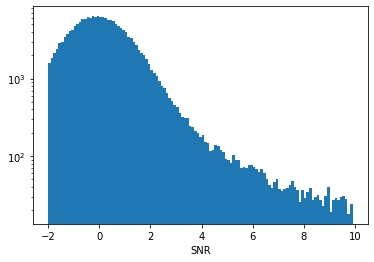

In [27]:
#Calculate upper limits on the radio flux from the LOFAR image for the HELP objects
ras = joined_cigale_lofar_mstar['ra']
decs = joined_cigale_lofar_mstar['dec']

x,y = np.round(radim_wcs_err.wcs_world2pix(ras,decs,0,ra_dec_order=True),0).astype(int)
rad_errs = radim_err[x,y]
rad_upper_lims = rad_errs*5

x,y = np.round(radim_wcs.wcs_world2pix(ras,decs,0,ra_dec_order=True),0).astype(int)
rad_flux = radim_data[x,y]

SNR = rad_flux/rad_errs
bins = np.arange(-2,10,0.1)
plt.hist(SNR,bins=bins,log=True)

plt.xlabel('SNR')
plt.show()

In [59]:
#calculate FIR luminosities and radio luminsoities

#get Ldust from SED fits for LOFAR sources
ldust_colnames = ['Ldust_best']
ldust_err_colnames = ['Ldust_sigma']
sed_fitters = ['magphys']
lofar_ldust,lofar_ldust_err = get_best_ldust(lofar_sed,ldust_colnames,ldust_err_colnames,sed_fitters)


#add in the ldust measurments from CIGALE for HELP sources
help_ldust = joined_cigale_HELP['bayes.dust.luminosity']
help_ldust_err = joined_cigale_HELP['bayes.dust.luminosity_err']

#radio luminosities for the LOFAR sources
radio_flux = lofar_sed['Peak_flux']
radio_flux_err = lofar_sed['E_Peak_flux']

redshift = lofar_sed['Z_BEST']
mask = redshift<=0
redshift[mask] = 0.001

dist = cosmo.luminosity_distance(redshift).to(u.m).value

alpha=-0.8

lum_rad_lofar = radio_flux*4*np.pi*dist**2 * 1E-26 / (1+redshift)**(1+alpha)
#mask out nan luminosities caused by radio sources with no redshift
mask = (~np.isnan(redshift)) & (~np.isnan(lofar_ldust))
lum_rad_lofar = lum_rad_lofar[mask]
lofar_ldust = lofar_ldust[mask]

#radio luminosties for the HELP sources
redshift_help = joined_cigale_HELP['bayes.universe.redshift']
mask = redshift_help<=0
redshift_help[mask] = 0.001

dist = cosmo.luminosity_distance(redshift_help).to(u.m).value

alpha=-0.8

lum_rad_upper = rad_upper_lims*4*np.pi*dist**2 * 1E-26 / (1+redshift_help)**(1+alpha)


#create the joint LOFAR, HELP radio luminosity array
lum_rad = np.append(lum_rad_lofar.data.data,lum_rad_upper)
#convert the radio luminosities to watts from Janskys
lum_rad = lum_rad/1E26

#create a joint ldust array
ldust = np.append(lofar_ldust,help_ldust)
ldust_err = np.append(lofar_ldust_err,help_ldust_err)
#convert FIR luminosities to Watts
#ldust = ldust*3.8E26
#ldust_err = ldust_err*3.8E26

In [60]:
#set flags for detection in the radio map

#all the lum_rad_lofar sources are detected and all the HELP sources are not detected
det_radio = np.append(np.ones(len(lum_rad_lofar)),np.zeros(len(rad_upper_lims)))

measured median from the detections is: 27.409530632932913


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


measured median using survival analysis is: 28.0556060916215


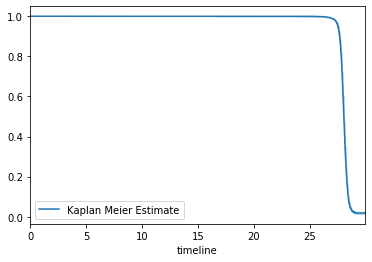

median q = 1.4758224950046888


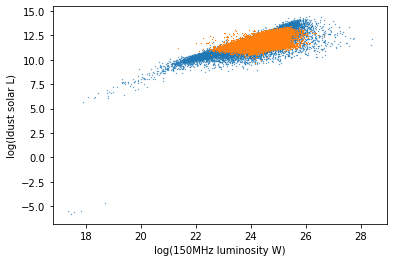

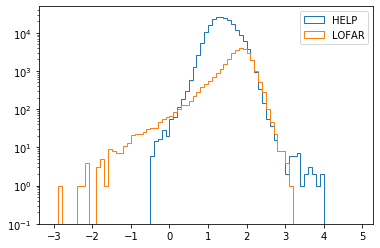

In [61]:
q = np.log10(ldust/3.75E12) - np.log10(lum_rad)
mask = ~np.isinf(q)
const = np.max(q)
#q = const - q
#q_lim = const - q_lim

data = q[mask]
#data[flag_detected] = q_lim[flag_detected]
det = det_radio[mask]
print('measured median from the detections is: {}'.format(np.median(data)))

kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
print('measured median using survival analysis is: {}'.format(kmf.median_))
kmf.plot()
plt.show()

print('median q = {}'.format(kmf.median_-np.log10(3.8E26)))

y = np.log10(lofar_ldust/3.8E26)
x = np.log10(lum_rad_lofar)
plt.scatter(x,y,s=0.1)

x = np.log10(lum_rad_upper)
y = np.log10(help_ldust/3.8E26)
plt.scatter(x,y,s=0.1,marker='^')

plt.xlabel('log(150MHz luminosity W)')
plt.ylabel('log(ldust solar L)')
#plt.ylim(5.0,14)
plt.show()

bins = np.arange(-3,5,0.1)
q_help = np.log10(help_ldust/3.75E12) - np.log10(lum_rad_upper)
plt.hist(q_help,log=True,label='HELP',bins=bins,histtype='step')

q_lofar = np.log10(lofar_ldust/3.75E12) - np.log10(lum_rad_lofar)
plt.hist(q_lofar,log=True,label='LOFAR',bins=bins,histtype='step')
plt.legend()
plt.show()

In [15]:
y = np.log10(ldust_lofar/3.8E26)
x = np.log10(lum_rad_lofar)

In [36]:
ldust

array([1.26599994e+12, 5.86299998e+11, 8.37799969e+11, ...,
       2.12304482e+39, 1.61030990e+38, 2.77041353e+39])

## Calculate the FIRC for all sources that have a stellar mass above some limit

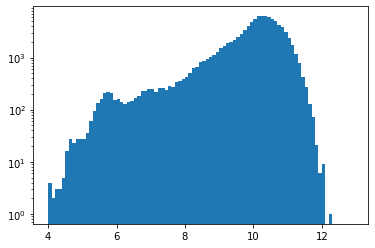

In [30]:
#look at the stellar mass distribution to decide on where to put the limit
data = joined_cigale_lofar_mstar['Mass_median']
bins = np.arange(4,13,0.1)
plt.hist(data,log=True,bins=bins)

plt.show()

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


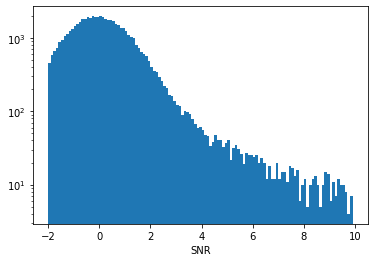

In [31]:
#Calculate upper limits on the radio flux from the LOFAR image for the HELP objects
mask = joined_cigale_lofar_mstar['Mass_median']>10
ras = joined_cigale_lofar_mstar['ra'][mask]
decs = joined_cigale_lofar_mstar['dec'][mask]

x,y = np.round(radim_wcs_err.wcs_world2pix(ras,decs,0,ra_dec_order=True),0).astype(int)
rad_errs = radim_err[x,y]
rad_upper_lims = rad_errs*5

x,y = np.round(radim_wcs.wcs_world2pix(ras,decs,0,ra_dec_order=True),0).astype(int)
rad_flux = radim_data[x,y]

SNR = rad_flux/rad_errs
bins = np.arange(-2,10,0.1)
plt.hist(SNR,bins=bins,log=True)

plt.xlabel('SNR')
plt.show()

In [33]:
#calculate FIR luminosities and radio luminsoities

#get Ldust from SED fits for LOFAR sources
ldust_colnames = ['Ldust_best']
ldust_err_colnames = ['Ldust_sigma']
sed_fitters = ['magphys']
lofar_ldust,lofar_ldust_err = get_best_ldust(lofar_sed,ldust_colnames,ldust_err_colnames,sed_fitters)

mask_lofar_mass = lofar_sed['Mass_median']>10
lofar_ldust = lofar_ldust[mask_lofar_mass]
lofar_ldust_err = lofar_ldust_err[mask_lofar_mass]

#add in the ldust measurments from CIGALE for HELP sources
mask_help_mass = joined_cigale_lofar_mstar['Mass_median']>10
help_ldust = joined_cigale_lofar_mstar['bayes.dust.luminosity'][mask_help_mass]
help_ldust_err = joined_cigale_lofar_mstar['bayes.dust.luminosity_err'][mask_help_mass]

#radio luminosities for the LOFAR sources
radio_flux = lofar_sed['Peak_flux'][mask_lofar_mass]
radio_flux_err = lofar_sed['E_Peak_flux'][mask_lofar_mass]

redshift = lofar_sed['Z_BEST'][mask_lofar_mass]
mask = redshift<=0
redshift[mask] = 0.001

dist = cosmo.luminosity_distance(redshift).to(u.m).value

alpha=-0.8

lum_rad_lofar = radio_flux*4*np.pi*dist**2 * 1E-26 / (1+redshift)**(1+alpha)
#mask out nan luminosities caused by radio sources with no redshift
mask = (~np.isnan(redshift)) & (~np.isnan(lofar_ldust))
lum_rad_lofar = lum_rad_lofar[mask]
lofar_ldust = lofar_ldust[mask]

#radio luminosties for the HELP sources
redshift_help = joined_cigale_lofar_mstar['bayes.universe.redshift'][mask_help_mass]
mask = redshift_help<=0
redshift_help[mask] = 0.001

dist = cosmo.luminosity_distance(redshift_help).to(u.m).value

alpha=-0.8

lum_rad_upper = rad_upper_lims*4*np.pi*dist**2 * 1E-26 / (1+redshift_help)**(1+alpha)


#create the joint LOFAR, HELP radio luminosity array
lum_rad = np.append(lum_rad_lofar.data.data,lum_rad_upper)
#convert the radio luminosities to watts from Janskys
lum_rad = lum_rad/1E26

#create a joint ldust array
ldust = np.append(lofar_ldust,help_ldust)
ldust_err = np.append(lofar_ldust_err,help_ldust_err)

#set flags for detection in the radio map

#all the lum_rad_lofar sources are detected and all the HELP sources are not detected
det_radio = np.append(np.ones(len(lum_rad_lofar)),np.zeros(len(rad_upper_lims)))

measured median from the detections is: 27.50001687616234
measured median using survival analysis is: 28.006998042519616


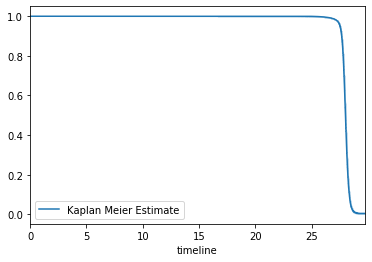

median q = 1.4272144459028056


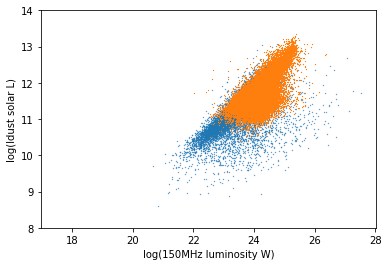

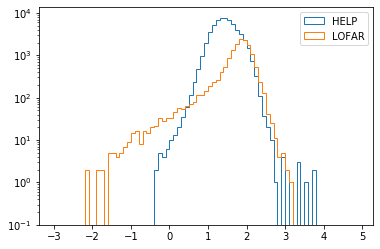

In [35]:
q = np.log10(ldust/3.75E12) - np.log10(lum_rad)
mask = ~np.isinf(q)
const = np.max(q)
#q = const - q
#q_lim = const - q_lim

data = q[mask]
#data[flag_detected] = q_lim[flag_detected]
det = det_radio[mask]
print('measured median from the detections is: {}'.format(np.median(data)))

kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
print('measured median using survival analysis is: {}'.format(kmf.median_))
kmf.plot()
plt.show()

print('median q = {}'.format(kmf.median_-np.log10(3.8E26)))

y = np.log10(lofar_ldust/3.8E26)
x = np.log10(lum_rad_lofar)
plt.scatter(x,y,s=0.1)

x = np.log10(lum_rad_upper)
y = np.log10(help_ldust/3.8E26)
plt.scatter(x,y,s=0.1,marker='^')

plt.xlabel('log(150MHz luminosity W)')
plt.ylabel('log(ldust solar L)')
plt.ylim(8.0,14)
plt.show()

bins = np.arange(-3,5,0.1)
q_help = np.log10(help_ldust/3.75E12) - np.log10(lum_rad_upper)
plt.hist(q_help,log=True,label='HELP',bins=bins,histtype='step')

q_lofar = np.log10(lofar_ldust/3.75E12) - np.log10(lum_rad_lofar)
plt.hist(q_lofar,log=True,label='LOFAR',bins=bins,histtype='step')
plt.legend()
plt.show()